# Homework 06 — IANNwTF
## Group 27
Deadline: Dec 5, 2021 23:59

<https://forms.gle/8qwiuUXCfLjKGeg67>

In [1]:
# unimportant libraries
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
%config InlineBackend.figure_format = 'retina'

## Dataset

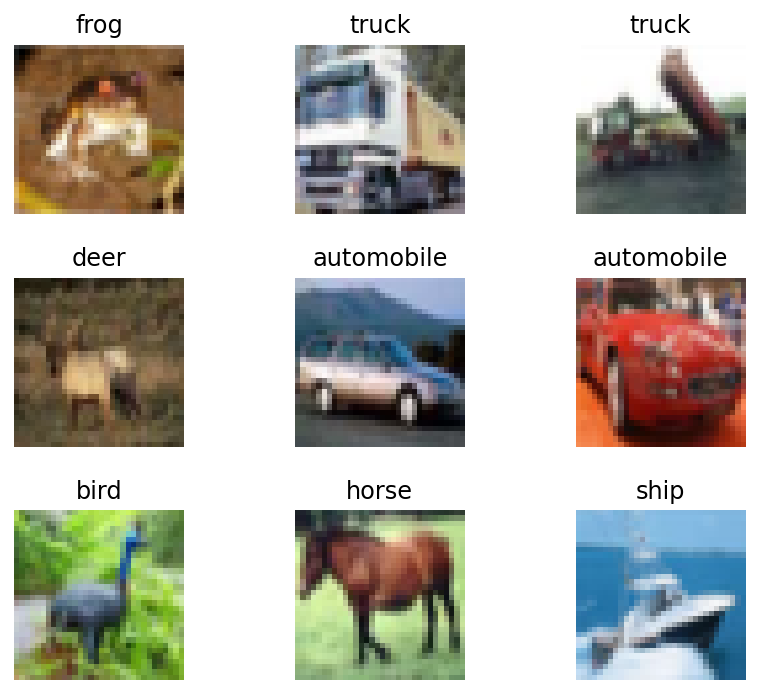

In [2]:
(training_inputs, training_labels), (test_inputs, test_labels) = tf.keras.datasets.cifar10.load_data()

text_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
fig, ax = plt.subplots(3,3, figsize=(6,5))
fig.tight_layout()
ax = ax.flatten()
for i in range(9):
    image = training_inputs[i]
    label = text_labels[training_labels[i][-1]]
    ax[i].imshow(image)
    ax[i].set_title(label)
    ax[i].axis("off")

In [3]:
def prepare_data(ds):
    # normalise images and then one-hot-encode the targets
    ds = ds.map(lambda inputs, targets: ((2*(inputs/255)-1), tf.one_hot(tf.squeeze(targets), 10)))
    # batch, shuffle and prefetch
    ds = ds.batch(batch_size).shuffle(batch_size).prefetch(128)
    return ds

In [4]:
batch_size = 64

# split into training, valid, and test datasets
training_dataset = tf.data.Dataset.from_tensor_slices((training_inputs, training_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels))

# prepare the datasets
training_dataset = prepare_data(training_dataset)
test_dataset = prepare_data(test_dataset)   

input_shape=(batch_size,32,32,3)
num_classes = 10

3. As the blocks are basically layers, make sure they are callable by inheriting from tf.keras.layers.Layer/tf.keras.Model
4. Good starting point: Use three convolution/batch normalization alterations with kernel sizes of 1,3,1 respectively. Make sure that the number of filters in the last convolutional layer match the channel dimension of your input.
5. Remember to use a training flag when using Batch Normalization. In the end, the output of your block should be added to the original input of your block.
6. At best use global average pooling followed by a dense layer (with 10 units) and softmax activation as your readout layers.
7. A way of doing that is to initialize the model’s Residual Blocks in a list whose length is determined by a parameter passed on to the models init function. You may want to have a look at inline-lists.
8. Remember to pass on a training flag that you pass on further to the calls of your residual blocks as they contain Batch Normalization layers.
9. Use a convolutional layer with kernel size 1 followed by Batch Norm, activation function and a Pooling layer. Check out tf.keras.layers.AveragePooling2D(strides=)
10. Check out tf.keras.layers.Concatenate()
11. You will also want to use Batch Norm here.
12. Again check out inline-lists.
13. You could implement this by creating an empty list and then by using a for loop alternately append a Dense Block and A Transition Layer to this list.
14. You will not want to include a Transition Layer after the last Dense Block
15. Pass on (number of convolution blocks in your dense blocks * growth rate on as the number of channels parameters to your Transition Layer
16. At best use another set of Batch Norm and global average pooling followed by a dense layer (with 10 units, softmax activation) as your readout layers.
17. If you used inline list, you will need to loop through them in the call. Again remember to pass on a boolean training flag to all parts where Batch Normalization is used.


## Model
### ResNet

In [5]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self):
        super(ResidualBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters = 64,
                                            kernel_size = 1,
                                            padding="same",
                                            input_shape=input_shape)
        self.conv2 = tf.keras.layers.Conv2D(filters = 64,
                                            kernel_size = 3,
                                            padding="same")
        self.conv3 = tf.keras.layers.Conv2D(filters = 64,
                                            kernel_size = 1,
                                            padding="same")
        
        self.batch_norm = tf.keras.layers.BatchNormalization()

    
    def call(self, original_input, training = True):
        x = self.conv1(original_input)
        x = self.batch_norm(x, training)
        x = self.conv2(x)
        x = self.batch_norm(x, training)
        x = self.conv3(x)
        x = self.batch_norm(x, training)
        return original_input + x

Implement a callable ResNet class, consisting of a convolutional layer followed by
multiple Residual Blocks and an output layer. 6
To further explore your networks behaviour, it might be convenient to implement
it in a way that you can easily alter the number of Residual Blocks. 7
Implement the network’s call function. 8

In [6]:
class ResNetModel(tf.keras.Model):

    def __init__(self, **kwargs):
        super(ResNetModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size =1)
        self.res1 = ResidualBlock()
        self.res2 = ResidualBlock()
        self.res3 = ResidualBlock()
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(num_classes,activation='softmax')
        
    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.res1(x, training=training)
        x = self.res2(x, training=training)
        x = self.res3(x, training=training)
        x = self.flatten(x)
        output = self.dense(x)
        return output


### DenseNet

## Training and 📈

In [7]:
@tf.function
def train_step(model, inputs, targets, loss_fn, optimizer, loss_metric, accuracy_metric):
    # training step
    with tf.GradientTape() as tape:
      predictions = model(inputs, training=True)
      loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    logs = {}
    accuracy_metric.update_state(targets, predictions)
    logs[accuracy_metric.name] = accuracy_metric.result()
    loss_metric.update_state(loss)
    logs["loss"] = loss_metric.result()
    return logs
    
@tf.function
def test_step(inputs, targets, loss_fn, loss_metric, accuracy_metric):
    # test step
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)
    logs = {}
    accuracy_metric.update_state(targets, predictions)
    logs["val_" + accuracy_metric.name] = accuracy_metric.result()
    loss_metric.update_state(loss)
    logs["val_loss"] = loss_metric.result()
    return logs

In [8]:
tf.keras.backend.clear_session()

# hyperparameters
num_epochs = 30
learning_rate = 0.001

# initialize the model
model = ResNetModel()
# initialize the loss function
loss_fn = tf.keras.losses.CategoricalCrossentropy()
# initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate, amsgrad = True)

# Metrics
accuracy_metric = tf.keras.metrics.CategoricalAccuracy()
loss_metric = tf.keras.metrics.Mean()
hist = {'loss': [], 'val_loss': [], 'categorical_accuracy': [], 'val_categorical_accuracy': []}


def reset_metrics(metrics):
    # utility function to reset the state of metrics
    for metric in metrics:
        metric.reset_state()

# training
for epoch in range(num_epochs):
    reset_metrics([accuracy_metric,loss_metric])
    for inputs, targets in training_dataset:
        logs = train_step(model, inputs, targets, loss_fn, optimizer, loss_metric, accuracy_metric)
    print(f"Results at the end of epoch {epoch}")
    for key, value in logs.items():
        hist[key].append(value)
        print(f"...{key}: {value:.4f}")
    
    # test
    reset_metrics([accuracy_metric,loss_metric])
    for (inputs_batch, targets_batch) in test_dataset:
        logs = test_step(inputs_batch, targets_batch, loss_fn, loss_metric, accuracy_metric)   
    print("...Evaluation results:")
    for key, value in logs.items():
        hist[key].append(value)
        print(f"...{key}: {value:.4f}")
    

Results at the end of epoch 0
...categorical_accuracy: 0.3365
...loss: 2.4171
...Evaluation results:
...val_categorical_accuracy: 0.1742
...val_loss: 2.2689
Results at the end of epoch 1
...categorical_accuracy: 0.3840
...loss: 1.8172
...Evaluation results:
...val_categorical_accuracy: 0.2270
...val_loss: 2.1517
Results at the end of epoch 2
...categorical_accuracy: 0.4026
...loss: 1.7506
...Evaluation results:
...val_categorical_accuracy: 0.2271
...val_loss: 2.1700
Results at the end of epoch 3
...categorical_accuracy: 0.4247
...loss: 1.6954
...Evaluation results:
...val_categorical_accuracy: 0.2439
...val_loss: 2.2350
Results at the end of epoch 4
...categorical_accuracy: 0.4324
...loss: 1.6676
...Evaluation results:
...val_categorical_accuracy: 0.2329
...val_loss: 2.1552
Results at the end of epoch 5
...categorical_accuracy: 0.4416
...loss: 1.6333
...Evaluation results:
...val_categorical_accuracy: 0.2334
...val_loss: 2.1424
Results at the end of epoch 6
...categorical_accuracy: 0.4

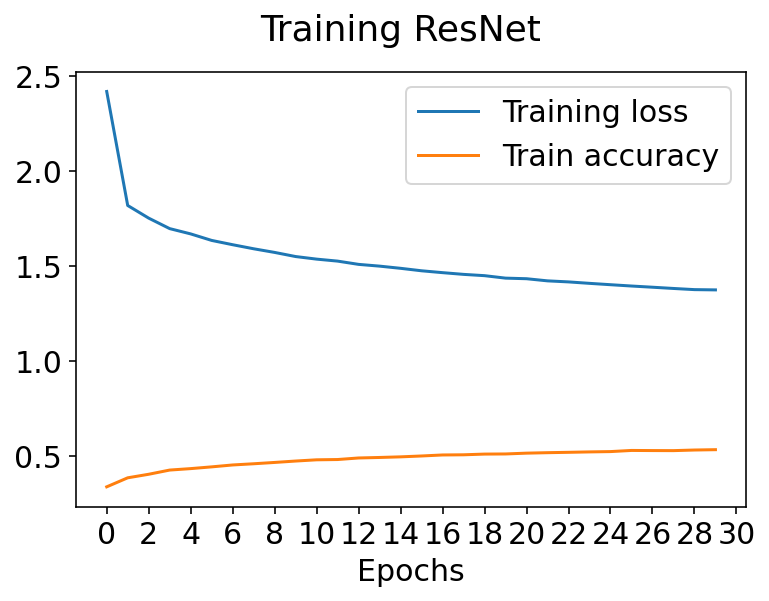

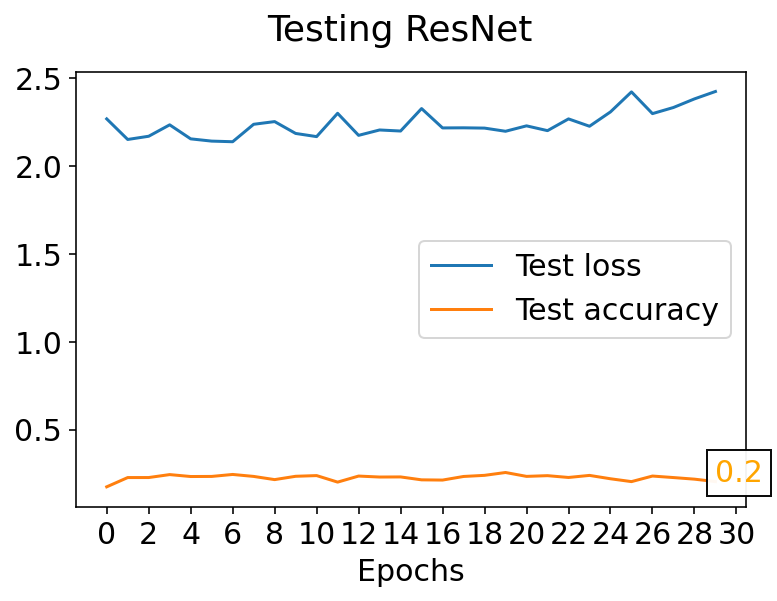

In [9]:
plt.rcParams['font.size'] = 15
plt.plot(hist['loss'], label='Training loss')
plt.plot(hist['categorical_accuracy'], label='Train accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(num_epochs + 1, step=2))
plt.legend()
plt.suptitle("Training ResNet")


plt.figure()
plt.suptitle("Testing ResNet")
plt.plot(hist['val_loss'], label='Test loss')
plt.plot(hist['val_categorical_accuracy'], label='Test accuracy')
plt.text(len(hist['val_categorical_accuracy'])-1,
         hist['val_categorical_accuracy'][-1],
         round(hist['val_categorical_accuracy'][-1].numpy(), 2),
         color = 'orange',
         bbox = dict(facecolor = 'white', alpha = 0.95))
plt.xticks(np.arange(num_epochs + 1, step=2))
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [10]:
model.summary()

Model: "res_net_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  256       
                                                                 
 residual_block (ResidualBlo  multiple                 45504     
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  multiple                 45504     
 lock)                                                           
                                                                 
 residual_block_2 (ResidualB  multiple                 45504     
 lock)                                                           
                                                                 
 flatten (Flatten)           multiple                  0         
                                                     